Multi-style Generative Network for Real-time Transfer

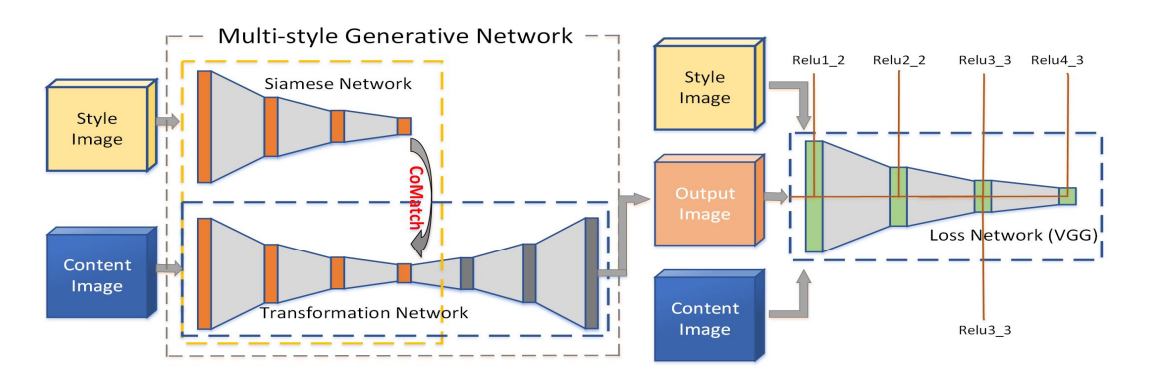

Пакеты

In [1]:
! pip install torchsummary

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms as tfs
from torchvision import datasets

from torchsummary import summary

from typing import List

from PIL import Image

import matplotlib.pyplot as plt

import os

import numpy as np

from glob import glob

from tqdm.auto import tqdm

import gc


import time

from IPython.display import clear_output
from IPython import display

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

VGG16

In [4]:
vgg16_pretrained = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).to(device)

In [5]:
class VGG16(torch.nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        vgg16_features = pretrained_model.features
        for (original_weight, new_weight) in zip(vgg16_features.parameters(), self.parameters()):
            new_weight.data[:] = original_weight

        self.eval()
        for parameter in self.parameters():
            parameter.requires_grad = False

    def forward(self, x):
        relu1_2 = self.conv1(x)
        h = F.max_pool2d(relu1_2, kernel_size=2, stride=2)

        relu2_2 = self.conv2(h)
        h = F.max_pool2d(relu2_2, kernel_size=2, stride=2)

        relu3_3 = self.conv3(h)
        h = F.max_pool2d(relu3_3, kernel_size=2, stride=2)

        relu4_3 = self.conv4(h)

        return [relu1_2, relu2_2, relu3_3, relu4_3]

MSG net

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        batch_size, channels, height, width = input.shape
        features = input.view(batch_size, channels, height * width)
        features_transposed = features.transpose(1,2)
        gram_matrix = torch.bmm(features, features_transposed).div(channels * height * width)
        return gram_matrix

In [7]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int) -> None:
        super().__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [8]:
class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int,
                 upsample: float = None) -> None:
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 4,
                 downsample: bool = False,
                 norm_layer=nn.BatchNorm2d) -> None:
        super().__init__()
        self.expansion = expansion
        self.downsample = downsample
        if self.downsample:
            self.residual_layer = nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride)
        self.conv_block = nn.Sequential(
            norm_layer(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            norm_layer(out_channels),
            nn.ReLU(inplace=True),
            ConvLayer(out_channels, out_channels, kernel_size=3, stride=stride),
            norm_layer(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.downsample:
            return self.residual_layer(x) + self.conv_block(x)
        return x + self.conv_block(x)

In [10]:
class UpsampleResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 2, expansion: int = 4,
                 norm_layer=nn.BatchNorm2d) -> None:
        super().__init__()
        self.expansion = expansion
        self.residual_layer = UpsampleConvLayer(in_channels, out_channels * self.expansion,
                                                kernel_size=1, stride=1, upsample=stride)
        self.conv_block = nn.Sequential(
            norm_layer(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            norm_layer(out_channels),
            nn.ReLU(inplace=True),
            UpsampleConvLayer(out_channels, out_channels, kernel_size=3, stride=1, upsample=stride),
            norm_layer(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.residual_layer(x) + self.conv_block(x)

In [11]:
class CoMatch(nn.Module):
    def __init__(self, shape: int, batch_size: int = 1) -> None:
        super(CoMatch, self).__init__()
        # batch_size is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1, shape, shape), requires_grad=True)
        # non-parameter buffer
        self.gram = torch.randn(batch_size, shape, shape, requires_grad=True)
        self.shape = shape
        self.product = torch.Tensor(batch_size, shape, shape)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        self.weight.data.uniform_(0.0, 0.02)

    def set_target(self, target: torch.Tensor) -> None:
        self.gram = target

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input x is a 3D feature map
        self.product = torch.bmm(self.weight.expand_as(self.gram), self.gram)
        return torch.bmm(self.product.transpose(1, 2).expand(x.size(0), self.shape, self.shape),
                         x.view(x.size(0), x.size(1), -1)).view_as(x)

    def __repr__(self):
        return self.__class__.__name__ + f"(N x {self.shape})"

In [12]:
class MSGNet(nn.Module):
    # ngf - number of generator filter channels
    def __init__(self, input_nc: int = 3, output_nc: int = 3, ngf: int = 128, expansion: int = 4,
                 norm_layer=nn.InstanceNorm2d,
                 n_blocks: int = 6,
                 gpu_ids: List = None):
        super().__init__()
        if gpu_ids is not None:
            self.gpu_ids = gpu_ids
        else:
            self.gpu_ids = []

        self.gram = GramMatrix()
        self.expansion = expansion
        self.norm_layer = norm_layer

        self.model1 = nn.Sequential(ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                                    norm_layer(64),
                                    nn.ReLU(inplace=True),
                                    ResidualBlock(64, 32, 2, self.expansion, True, self.norm_layer),
                                    ResidualBlock(32 * self.expansion, ngf, 2, self.expansion, True, self.norm_layer))

        model = []
        self.co_match = CoMatch(ngf * self.expansion)
        model.append(self.model1)
        model.append(self.co_match)

        for i in range(n_blocks):
            model.append(ResidualBlock(ngf * self.expansion, ngf, 1, self.expansion, False, self.norm_layer))

        model += [UpsampleResidualBlock(ngf * self.expansion, 32, 2, self.expansion, self.norm_layer),
                  UpsampleResidualBlock(32 * self.expansion, 16, 2, self.expansion, self.norm_layer),
                  norm_layer(16 * self.expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16 * self.expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def set_target(self, x):
        x1 = self.model1(x)
        xg = self.gram(x1)
        self.co_match.set_target(xg)

    def forward(self, x):
        return self.model(x)


Microsoft COCO

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
#! unzip -q /content/drive/MyDrive/msg-net/coco_dataset_resized.zip

In [15]:
os.mkdir("models")

FileExistsError: [Errno 17] File exists: 'models'

In [16]:
STYLE_PATH = "/kaggle/input/wtf-dataset/21styles/"
CONTENT_PATH = "/kaggle/input/wtf-dataset/coco_dataset_resized/content"
SAVE_MODEL_DIR = "/kaggle/working/models"
CONTENT_IMAGE_SIZE = 256
STYLE_IMAGE_SIZE = 512
BATCH_SIZE = 8

In [17]:
# display(Image.open(STYLE_PATH + 'candy.jpg').resize((STYLE_IMAGE_SIZE, STYLE_IMAGE_SIZE)))

In [18]:
# display(Image.open(CONTENT_PATH + 'coco_dataset_resized/000001.jpg').resize((CONTENT_IMAGE_SIZE, CONTENT_IMAGE_SIZE)))

In [19]:
#1/0

In [20]:
#torch.cuda.empty_cache()
#gc.collect()
#with torch.no_grad():
#    torch.cuda.empty_cache()
#gc.collect()

Content dataloader

In [21]:
transform = tfs.Compose([tfs.ToTensor(),
                         tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
# https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198

In [22]:
from copy import deepcopy

def normalize_image(image):
    image = deepcopy(image)
    image[0] = (image[0] - 0.485) / 0.229
    image[1] = (image[1] - 0.456) / 0.224
    image[2] = (image[2] - 0.406) / 0.225
    return image

def restore_image(image):
    image = deepcopy(image)
    image * 1.
    image[0] = image[0] * 0.229 + 0.485
    image[1] = image[1] * 0.224 + 0.456
    image[2] = image[2] * 0.225 + 0.406
    return image


In [23]:
#!rm -R /content/content/.ipynb_checkpoints

In [24]:
content_dataset = datasets.ImageFolder(CONTENT_PATH, transform)
content_dataloader = DataLoader(content_dataset, BATCH_SIZE, pin_memory=True)

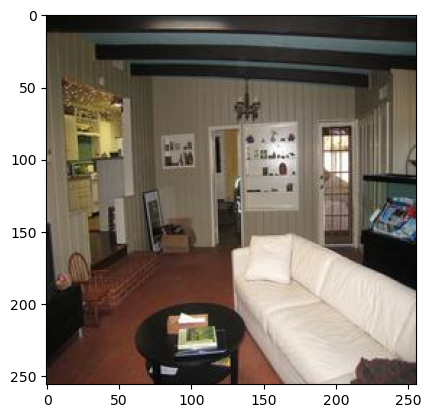

In [25]:
plt.imshow(restore_image(content_dataset[1][0]).permute(1, 2, 0))

Style dataloader

In [26]:
class StyleImageDataset(Dataset):
    def __init__(self, root_dir: str, resolution: int = 512) -> None:
        self.root_dir = root_dir
        self.resolution = resolution
        self.tensors = []
        images = glob(os.path.join(root_dir,"*.jpg"))
        for image_path in images:
            with open(image_path, 'rb') as file:
                image = Image.open(file)
                image = image.convert("RGB")
                image = image.resize((self.resolution, self.resolution), Image.LANCZOS)
                image = np.asarray(image)
                image = image / 255.
                image = image.transpose(2, 0, 1)
                image = normalize_image(image)
                image = torch.from_numpy(image).float()
                self.tensors.append(image.unsqueeze(0))

    def __getitem__(self, idx):
        return self.tensors[idx % len(self.tensors)]

    def __len__(self):
        return len(self.tensors)


In [27]:
style_dataset = StyleImageDataset(STYLE_PATH)

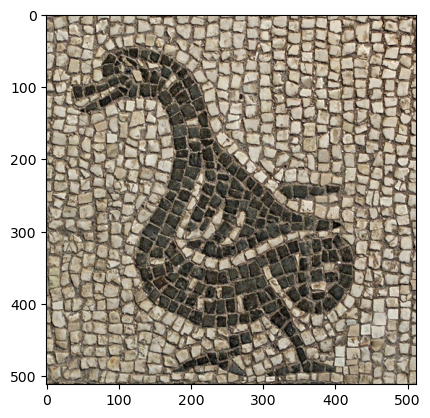

In [28]:
plt.imshow(restore_image(style_dataset[1][0]).permute(1, 2, 0))

Train

In [29]:
clip = lambda x : np.clip(x, 0, 1)

def show_images(dh, style, content, result):
    fig, axes = plt.subplots(1,3, figsize=(6, 2))
    axes[0].imshow(clip(restore_image(style).permute(1, 2, 0).numpy()))
    axes[1].imshow(clip(restore_image(content).permute(1, 2, 0).numpy()))
    axes[2].imshow(clip(restore_image(result).permute(1, 2, 0).numpy()))
    dh.update(fig)

In [33]:
def train(style_model, vgg_model, criterion, optimizer, content_dataloader, style_dataset, 
          epochs = 3, 
          content_weight = 1.0, 
          style_weight = 50000.0, 
          log_interval = 500):
    style_model = style_model.to(device)

    vgg_model = vgg_model.to(device)
    vgg_model.eval()

    fig, axes = plt.subplots(1,3, figsize=(6, 2))
    dh = display.display(fig, display_id=True)

    gram_matrix = GramMatrix()
    with tqdm(range(epochs),desc='Epoch') as epoch_range:
        for epoch in epoch_range:
            style_model.train()
            agg_content_loss = 0
            agg_style_loss = 0
            count = 0
            for batch_id, (x, _) in enumerate(tqdm(content_dataloader, desc="Batch", leave = True)):
                n_batch = len(x)
                count += n_batch
                optimizer.zero_grad()
                x = x.to(device)
                style_tensor = style_dataset[batch_id].to(device)
                style_model.set_target(style_tensor)

                features_style = vgg_model(style_tensor)
                gram_style = [gram_matrix(y) for y in features_style]

                y = style_model(x)
                xc = x.detach()

                features_y = vgg_model(y)
                features_xc = vgg_model(xc)

                f_xc_c = features_xc[1].detach()

                content_loss = content_weight * criterion(features_y[1], f_xc_c)

                style_loss = 0.

                for m in range(len(features_y)):
                    gram_y = gram_matrix(features_y[m])
                    gram_s = gram_style[m].detach().repeat(n_batch, 1, 1)
                    style_loss += style_weight * criterion(gram_y, gram_s[:n_batch, :, :])

                #print(f"content loss = {content_loss}, style loss = {style_loss}")
                total_loss = content_loss + style_loss
                total_loss.backward()
                optimizer.step()

                agg_content_loss += content_loss.detach().cpu()
                agg_style_loss += style_loss.detach().cpu()
                if (batch_id + 1) % 50 == 0:
                    plt.clf()
                    plt.close("all")
                    show_images(dh, style_tensor[0].clone().detach().cpu(), x[0].clone().detach().cpu(), y[0].clone().detach().cpu())

                if (batch_id + 1) % log_interval == 0:
                    mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                        time.ctime(), epoch + 1, count, len(content_dataset),
                                    agg_content_loss / (batch_id + 1),
                                    agg_style_loss / (batch_id + 1),
                                    (agg_content_loss + agg_style_loss) / (batch_id + 1)
                    )
                    epoch_range.set_description(mesg)


                if (batch_id + 1) % (4 * log_interval) == 0:
                    # save model
                    style_model.eval()
                    style_model.cpu()
                    save_model_filename = "Epoch_" + str(epoch) + "iters_" + str(count) + "_" + \
                        str(time.ctime()).replace(' ', '_') + "_" + str(
                        content_weight) + "_" + str(style_weight) + ".model"
                    save_model_path = os.path.join(SAVE_MODEL_DIR, save_model_filename)
                    torch.save(style_model.state_dict(), save_model_path)
                    style_model.train()
                    style_model.cuda()
                    epoch_range.set_description("\nCheckpoint, trained model saved at", save_model_path)

                if (batch_id + 1) % 5000 == 0:
                    style_model.eval()
                    style_model = style_model.cpu()
                    torch.save(style_model.state_dict(), 'msgnet_checkpoint.pth')
                    style_model = style_model.cuda()
                    style_model.train()

    # save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(SAVE_MODEL_DIR, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [34]:
style_model = MSGNet()

vgg = VGG16(vgg16_pretrained)

optimizer = torch.optim.Adam(style_model.parameters(), 1e-3)

criterion = torch.nn.MSELoss()

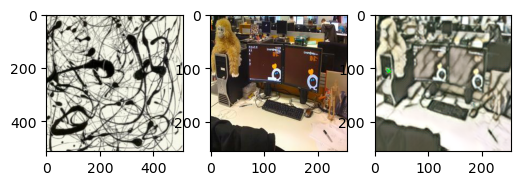

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/15426 [00:00<?, ?it/s]

Batch:   0%|          | 0/15426 [00:00<?, ?it/s]

Batch:   0%|          | 0/15426 [00:00<?, ?it/s]


Done, trained model saved at /kaggle/working/models/Final_epoch_3_Sun_Jul__9_07:47:35_2023_1.0_50000.0.model


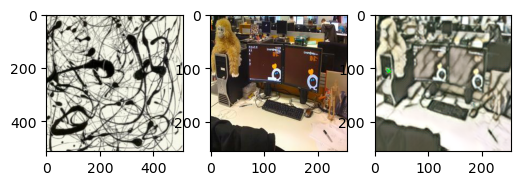

In [35]:
train(
    style_model = style_model,
    vgg_model = vgg,
    criterion = criterion,
    optimizer = optimizer,
    content_dataloader = content_dataloader,
    style_dataset = style_dataset,
)